In [ ]:
import os
import torch
import gpytorch
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_dir = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'))
df['tau_ab_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['ptau_ab_ratio'] = df['PTAU_bl'] / df['ABETA_bl']
df['A+'] = df['ABETA_bl'].apply(lambda x: 1 if x < 880 else 0)
df['T+'] = df['ptau_ab_ratio'].apply(lambda x: 1 if x > 0.028 else 0)
df['N+'] = df['tau_ab_ratio'].apply(lambda x: 1 if x > 0.33 else 0)
df = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'tau_ab_ratio', 'ptau_ab_ratio'])

In [3]:
class SVM(torch.nn.Module):
    def __init__(self, features, targets):
        super(SVM, self).__init__()
        self.features = features
        self.targets = targets
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()

    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

# STL

## Predict A+

In [4]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['A+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [5]:
model = SVM(X_train, y_train).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

KeyboardInterrupt: 

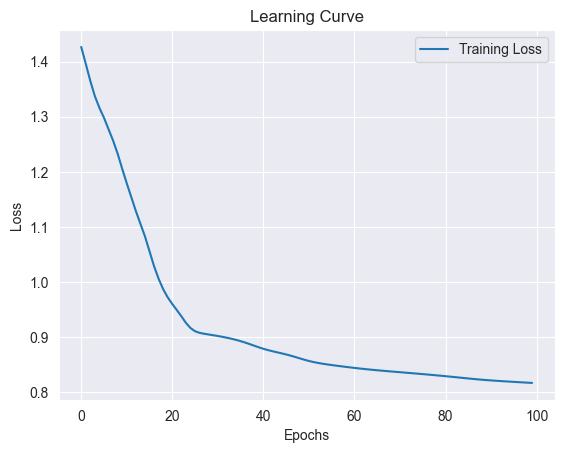

In [6]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [7]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.8271889400921659
Precision: 0.8472906403940886
Recall: 0.7962962962962963
F1 Score: 0.8210023866348449


In [8]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))

Test Accuracy: 0.8348623853211009
Test Precision: 0.8541666666666666
Test Recall: 0.7884615384615384
Test F1 Score: 0.8200000000000001


# Predict T+

In [9]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['T+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [11]:
model = SVM(X_train, y_train, ).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.4196
Epoch [2/100], Loss: 1.3479
Epoch [3/100], Loss: 1.2855
Epoch [4/100], Loss: 1.2296
Epoch [5/100], Loss: 1.1772
Epoch [6/100], Loss: 1.1262
Epoch [7/100], Loss: 1.0774
Epoch [8/100], Loss: 1.0331
Epoch [9/100], Loss: 0.9936
Epoch [10/100], Loss: 0.9611
Epoch [11/100], Loss: 0.9362
Epoch [12/100], Loss: 0.9167
Epoch [13/100], Loss: 0.9009
Epoch [14/100], Loss: 0.8874
Epoch [15/100], Loss: 0.8759
Epoch [16/100], Loss: 0.8656
Epoch [17/100], Loss: 0.8563
Epoch [18/100], Loss: 0.8477
Epoch [19/100], Loss: 0.8401
Epoch [20/100], Loss: 0.8335
Epoch [21/100], Loss: 0.8279
Epoch [22/100], Loss: 0.8233
Epoch [23/100], Loss: 0.8195
Epoch [24/100], Loss: 0.8162
Epoch [25/100], Loss: 0.8133
Epoch [26/100], Loss: 0.8105
Epoch [27/100], Loss: 0.8079
Epoch [28/100], Loss: 0.8053
Epoch [29/100], Loss: 0.8027
Epoch [30/100], Loss: 0.8001
Epoch [31/100], Loss: 0.7974
Epoch [32/100], Loss: 0.7948
Epoch [33/100], Loss: 0.7920
Epoch [34/100], Loss: 0.7893
Epoch [35/100], Loss: 0

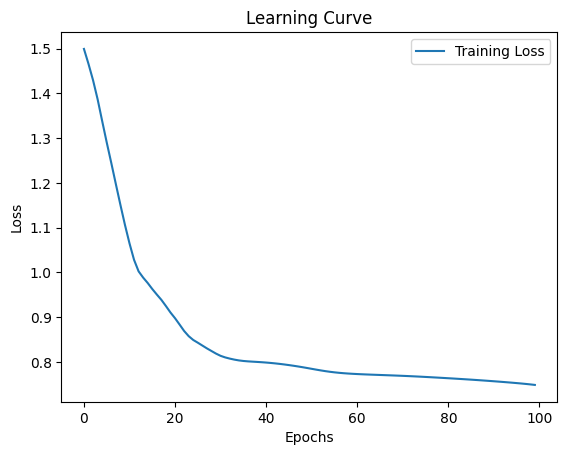

In [196]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [197]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.8894009216589862
Precision: 0.885
Recall: 0.8762376237623762
F1 Score: 0.880597014925373


In [198]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))

Test Accuracy: 0.8807339449541285
Test Precision: 0.96
Test Recall: 0.8135593220338984
Test F1 Score: 0.8807339449541285


# Predict N+

In [199]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['N+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [200]:
model = SVM(X_train, y_train).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.3202
Epoch [2/100], Loss: 1.2629
Epoch [3/100], Loss: 1.2122
Epoch [4/100], Loss: 1.1681
Epoch [5/100], Loss: 1.1267
Epoch [6/100], Loss: 1.0867
Epoch [7/100], Loss: 1.0496
Epoch [8/100], Loss: 1.0180
Epoch [9/100], Loss: 0.9933
Epoch [10/100], Loss: 0.9749
Epoch [11/100], Loss: 0.9610
Epoch [12/100], Loss: 0.9495
Epoch [13/100], Loss: 0.9393
Epoch [14/100], Loss: 0.9299
Epoch [15/100], Loss: 0.9212
Epoch [16/100], Loss: 0.9132
Epoch [17/100], Loss: 0.9056
Epoch [18/100], Loss: 0.8980
Epoch [19/100], Loss: 0.8900
Epoch [20/100], Loss: 0.8817
Epoch [21/100], Loss: 0.8734
Epoch [22/100], Loss: 0.8653
Epoch [23/100], Loss: 0.8578
Epoch [24/100], Loss: 0.8511
Epoch [25/100], Loss: 0.8452
Epoch [26/100], Loss: 0.8399
Epoch [27/100], Loss: 0.8353
Epoch [28/100], Loss: 0.8314
Epoch [29/100], Loss: 0.8280
Epoch [30/100], Loss: 0.8252
Epoch [31/100], Loss: 0.8227
Epoch [32/100], Loss: 0.8206
Epoch [33/100], Loss: 0.8187
Epoch [34/100], Loss: 0.8170
Epoch [35/100], Loss: 0

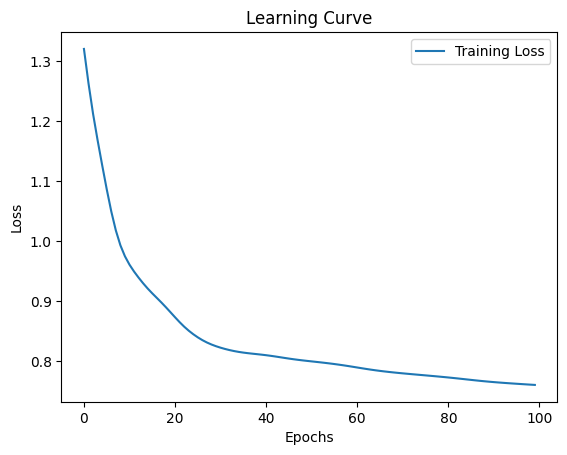

In [201]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [202]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.9055299539170507
Precision: 0.8805970149253731
Recall: 0.9123711340206185
F1 Score: 0.8962025316455695


In [203]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))

Test Accuracy: 0.8807339449541285
Test Precision: 0.9387755102040817
Test Recall: 0.8214285714285714
Test F1 Score: 0.8761904761904763


# MTL

In [179]:
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.classifier = torch.nn.Sigmoid()

    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return self.classifier(plane_output)

In [180]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df.filter(['A+', 'T+', 'N+'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [181]:
model = MultitaskSVM(X_train, y_train).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.5176
Epoch [2/100], Loss: 1.4802
Epoch [3/100], Loss: 1.4422
Epoch [4/100], Loss: 1.4031
Epoch [5/100], Loss: 1.3638
Epoch [6/100], Loss: 1.3257
Epoch [7/100], Loss: 1.2865
Epoch [8/100], Loss: 1.2463
Epoch [9/100], Loss: 1.2064
Epoch [10/100], Loss: 1.1667
Epoch [11/100], Loss: 1.1256
Epoch [12/100], Loss: 1.0883
Epoch [13/100], Loss: 1.0603
Epoch [14/100], Loss: 1.0385
Epoch [15/100], Loss: 1.0191
Epoch [16/100], Loss: 1.0027
Epoch [17/100], Loss: 0.9903
Epoch [18/100], Loss: 0.9803
Epoch [19/100], Loss: 0.9713
Epoch [20/100], Loss: 0.9628
Epoch [21/100], Loss: 0.9546
Epoch [22/100], Loss: 0.9464
Epoch [23/100], Loss: 0.9387
Epoch [24/100], Loss: 0.9316
Epoch [25/100], Loss: 0.9249
Epoch [26/100], Loss: 0.9183
Epoch [27/100], Loss: 0.9118
Epoch [28/100], Loss: 0.9055
Epoch [29/100], Loss: 0.8994
Epoch [30/100], Loss: 0.8936
Epoch [31/100], Loss: 0.8883
Epoch [32/100], Loss: 0.8833
Epoch [33/100], Loss: 0.8786
Epoch [34/100], Loss: 0.8741
Epoch [35/100], Loss: 0

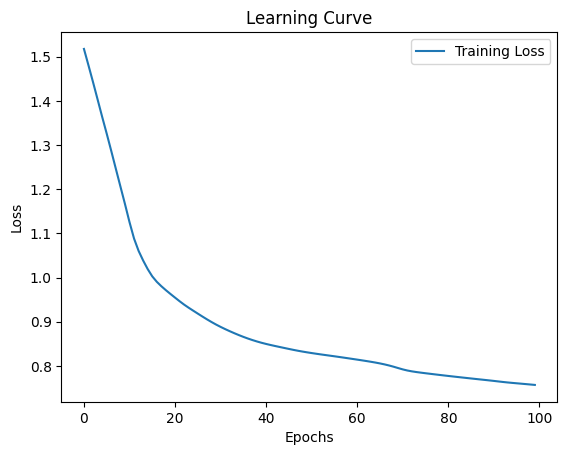

In [182]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [183]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    # For multitask (MTL) evaluation
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np, average='macro'))
    print("Recall:", recall_score(y_train_np, y_pred_np, average='macro'))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np, average='macro') * recall_score(y_train_np, y_pred_np, average='macro')) /
          (precision_score(y_train_np, y_pred_np, average='macro') + recall_score(y_train_np, y_pred_np, average='macro')))


Accuracy: 0.7672811059907834
Precision: 0.8803818535961393
Recall: 0.8686628480637563
F1 Score: 0.8744830908011624


In [184]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np, average='macro'))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np, average='macro'))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np, average='macro') * recall_score(y_test_np,
                                                                  y_test_pred_np, average='macro')) / (
              precision_score(y_test_np, y_test_pred_np, average='macro') + recall_score(y_test_np,
                                                                        y_test_pred_np, average='macro')))

Test Accuracy: 0.7155963302752294
Test Precision: 0.881633460878744
Test Recall: 0.8383034857691077
Test F1 Score: 0.8594226722855037
